<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_tensorflow2/blob/main/7_PRETRAIN_METHOD/KorQuAD_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 허깅페이스 transformers 라이브러리 가져오기

In [1]:
pip install transformers==3.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 769 kB 30.9 MB/s 
     |████████████████████████████████| 3.0 MB 63.8 MB/s 
     |████████████████████████████████| 880 kB 70.5 MB/s 
     |████████████████████████████████| 1.3 MB 64.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=09b80f9675cdc8772ea631e982c5c842feb168e5dfaac0230485e7b5042849d4
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


### konlpy 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [5]:
import os
import pprint

from konlpy.tag import Okt
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import json
from wordcloud import WordCloud
from random import sample, seed
from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer
from nltk.tokenize import sent_tokenize

seed(1234)
phoneme_tokenizer = Okt()

DATA_IN_PATH = './data_in'
save_path = "bert_ckpt/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False).save_pretrained(save_path)

bert_tokenizer = BertWordPieceTokenizer("bert_ckpt/vocab.txt", lowercase=False)

### 데이터 불러오기

In [6]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

3891200/3881058 [==============================] - 0s 0us/step


In [7]:
train_data = json.load(open(train_path))
dev_data = json.load(open(eval_path))

In [9]:
pprint.pprint(train_data['data'][0])

{'paragraphs': [{'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 '
                            '하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 '
                            '산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 '
                            '심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 '
                            '베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 '
                            '서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. '
                            '여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 '
                            '반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 '
                            '교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 '
                            '중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 '
                            '연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 '
                            '지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. '
                            '그 사이에 그는 리엔치와 방황하는 네덜란

### 텍스트 분석

In [10]:
documents = []
for d in train_data['data']:
    documents += [p['context'] for p in d['paragraphs']]
print('전체 텍스트 수: {}'.format(len(documents)))

전체 텍스트 수: 9681


### 어절 단위 길이 분석

In [11]:
len_docs = []
for d in documents:
    len_docs.append(len(d.split()))
    
print('텍스트 최대 길이: {}'.format(np.max(len_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_docs, 75)))

텍스트 최대 길이: 2244
텍스트 최소 길이: 7
텍스트 평균 길이: 114.87
텍스트 길이 표준편차: 47.57
텍스트 중간 길이: 102.0
제 1 사분위 텍스트 길이: 88.0
제 3 사분위 텍스트 길이: 127.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f8786ff3ad0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8786f80590>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8786ff34d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8786f86090>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8786f86b10>],
 'means': [<matplotlib.lines.Line2D at 0x7f88918c2290>]}

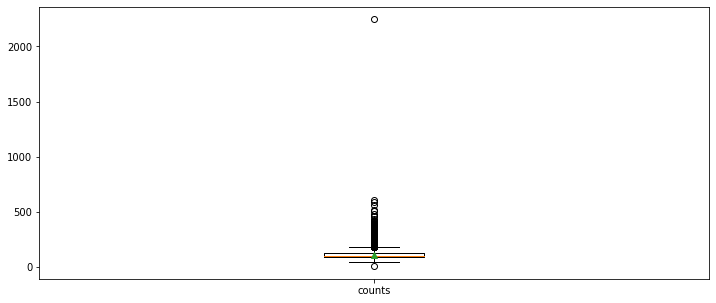

In [12]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([len_docs],
             labels=['counts'],
             showmeans=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8786a4cb10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8786a525d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8786a4c550>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8786a590d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8786a59b50>],
 'means': [<matplotlib.lines.Line2D at 0x7f8786a59610>]}

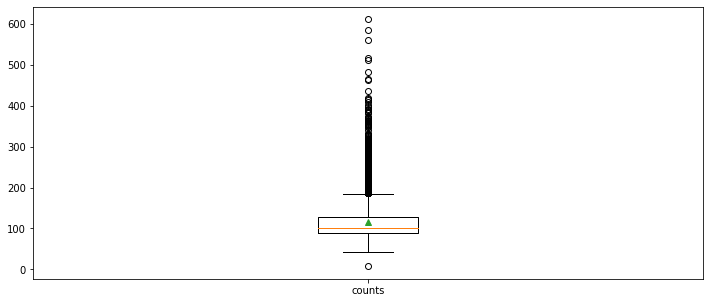

In [14]:
filtered_len_docs = [l for l in len_docs if l < 2000]

plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(filtered_len_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

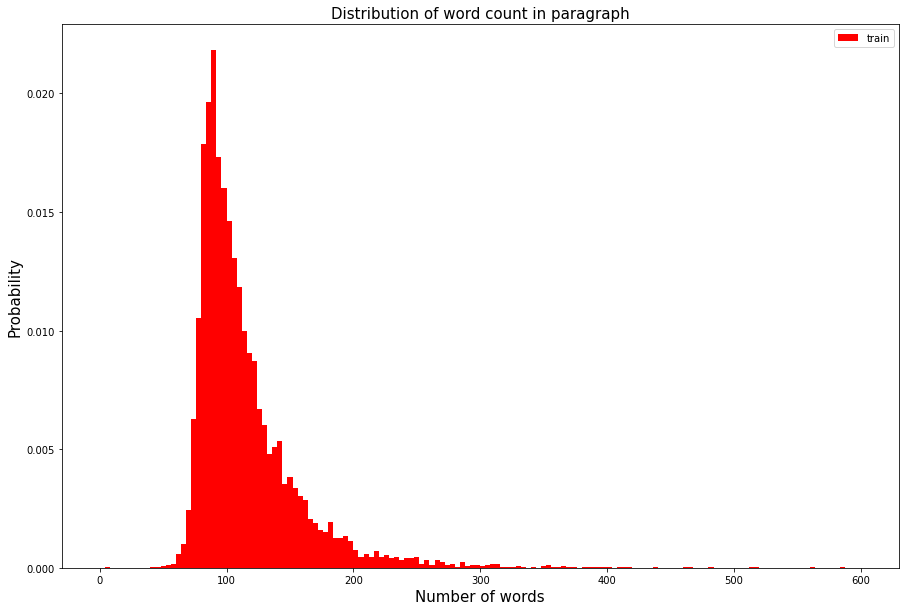

In [18]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_docs, bins=150, range=[0,600], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 버트 토크나이저 토큰 길이 분석

In [19]:
len_bert_tokenized_docs = []
for d in documents:
    len_bert_tokenized_docs.append(len(bert_tokenizer.encode(d, add_special_tokens=False).tokens))
    
print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_docs)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_docs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_docs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_docs)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_docs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_docs, 75)))

텍스트 최대 길이: 6367
텍스트 최소 길이: 120
텍스트 평균 길이: 311.88
텍스트 길이 표준편차: 129.44
텍스트 중간 길이: 279.0
제 1 사분위 텍스트 길이: 239.0
제 3 사분위 텍스트 길이: 344.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f87868b9410>,
 'caps': [<matplotlib.lines.Line2D at 0x7f87868d31d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f87869218d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8786885dd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8786835b90>],
 'means': [<matplotlib.lines.Line2D at 0x7f8786892e50>]}

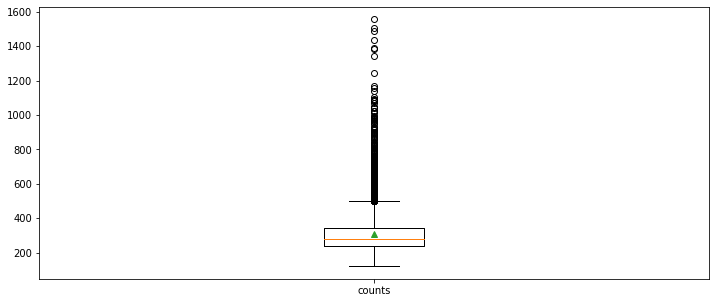

In [20]:
filtered_len_bert_tokenized_docs = [l for l in len_bert_tokenized_docs if l < 3000]

plt.figure(figsize=(12, 5))

plt.boxplot(filtered_len_bert_tokenized_docs,
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

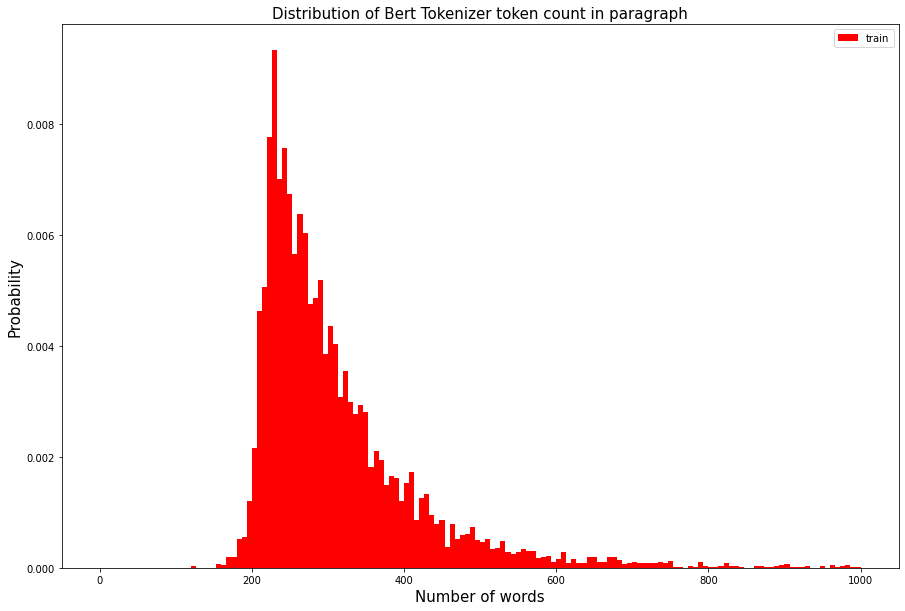

In [21]:
plt.figure(figsize=(15, 10))
plt.hist(filtered_len_bert_tokenized_docs, bins=150, range=[0,1000], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in paragraph", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 어휘 빈도 분석

In [29]:
cd drive/MyDrive/BERT

/content/drive/MyDrive/BERT


In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
sentences = []
for d in documents:
    sentences += sent_tokenize(d)

print('전체 문장 수: {}'.format(len(sentences)))
sampled_docs = sample(sentences, 20000)

전체 문장 수: 67884


(-0.5, 799.5, 599.5, -0.5)

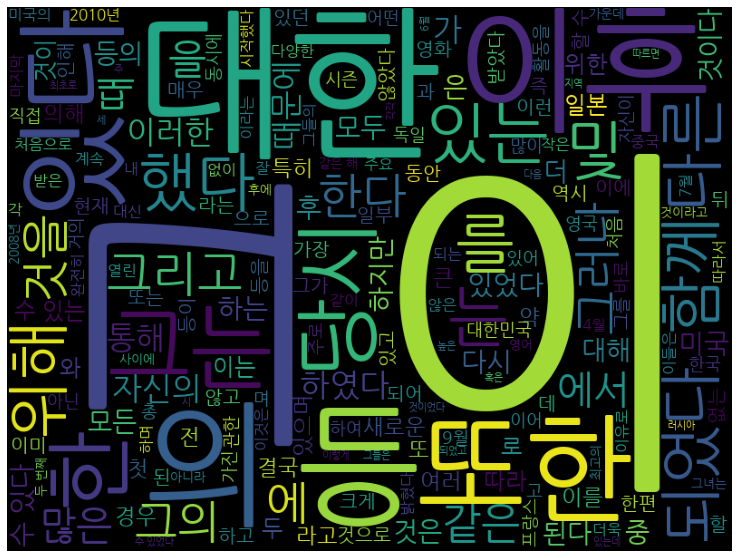

In [33]:
font_path = os.path.join(DATA_IN_PATH,'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

### 명사 토큰 기준

(-0.5, 799.5, 599.5, -0.5)

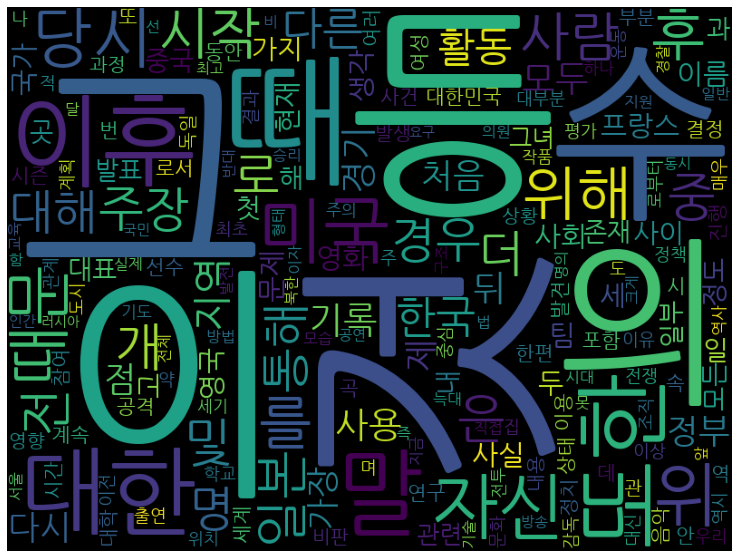

In [44]:
noun_extracted_docs = []
for d in sampled_docs:
    noun_extracted_docs += phoneme_tokenizer.nouns(d)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

### 질문 데이터 분석

In [34]:
questions = []
for d in train_data['data']:
    qas = [p['qas'] for p in d['paragraphs']]
    for c in qas:
        questions += [q['question'] for q in c]
    
print('전체 질문 수: {}'.format(len(questions)))

전체 질문 수: 60407


In [35]:
len_qs = []
for q in questions:
    len_qs.append(len(q.split()))
    
print('텍스트 최대 길이: {}'.format(np.max(len_qs)))
print('텍스트 최소 길이: {}'.format(np.min(len_qs)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_qs)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_qs)))
print('텍스트 중간 길이: {}'.format(np.median(len_qs)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_qs, 75)))

텍스트 최대 길이: 35
텍스트 최소 길이: 1
텍스트 평균 길이: 7.85
텍스트 길이 표준편차: 3.09
텍스트 중간 길이: 7.0
제 1 사분위 텍스트 길이: 6.0
제 3 사분위 텍스트 길이: 10.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f877f9c82d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f87800f20d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f877fc25cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8781004c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8781004110>],
 'means': [<matplotlib.lines.Line2D at 0x7f8781004590>]}

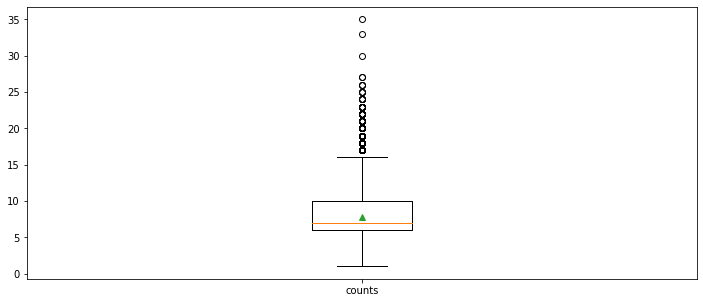

In [36]:
plt.figure(figsize=(12, 5))

plt.boxplot([len_qs],
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

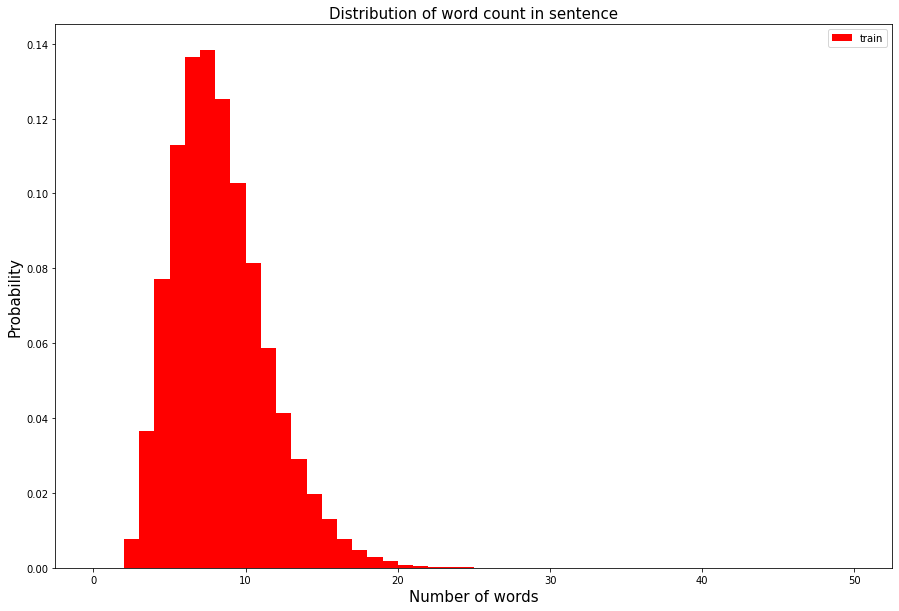

In [37]:
plt.figure(figsize=(15, 10))
plt.hist(len_qs, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of word count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 버트 토크나이저 토큰 길이 분석

In [38]:
len_bert_tokenized_q = []
for q in questions:
    len_bert_tokenized_q.append(len(bert_tokenizer.encode(q, add_special_tokens=False).tokens))
    
print('텍스트 최대 길이: {}'.format(np.max(len_bert_tokenized_q)))
print('텍스트 최소 길이: {}'.format(np.min(len_bert_tokenized_q)))
print('텍스트 평균 길이: {:.2f}'.format(np.mean(len_bert_tokenized_q)))
print('텍스트 길이 표준편차: {:.2f}'.format(np.std(len_bert_tokenized_q)))
print('텍스트 중간 길이: {}'.format(np.median(len_bert_tokenized_q)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 25)))
print('제 3 사분위 텍스트 길이: {}'.format(np.percentile(len_bert_tokenized_q, 75)))

텍스트 최대 길이: 91
텍스트 최소 길이: 4
텍스트 평균 길이: 22.07
텍스트 길이 표준편차: 7.96
텍스트 중간 길이: 21.0
제 1 사분위 텍스트 길이: 16.0
제 3 사분위 텍스트 길이: 27.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f877ed92590>,
 'caps': [<matplotlib.lines.Line2D at 0x7f877e305050>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f877ed87fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f877e305b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f877e2f4650>],
 'means': [<matplotlib.lines.Line2D at 0x7f877e2f4090>]}

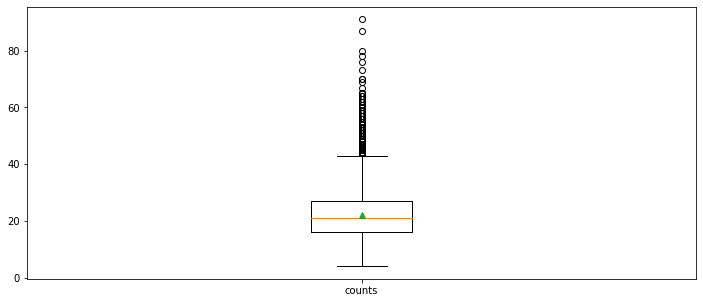

In [39]:
plt.figure(figsize=(12, 5))

plt.boxplot([len_bert_tokenized_q],
             labels=['counts'],
             showmeans=True)

Text(0, 0.5, 'Probability')

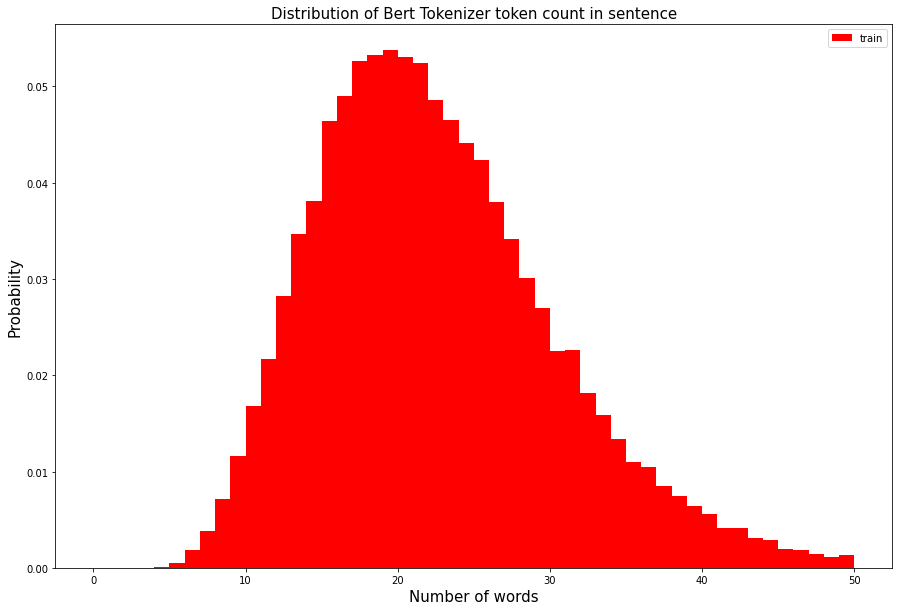

In [40]:
plt.figure(figsize=(15, 10))
plt.hist(len_bert_tokenized_q, bins=50, range=[0,50], facecolor='r', density=True, label='train')
plt.title("Distribution of Bert Tokenizer token count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### 질문 텍스트 어휘 빈도 북석

In [41]:
sampled_questions = sample(questions, 20000)

(-0.5, 799.5, 599.5, -0.5)

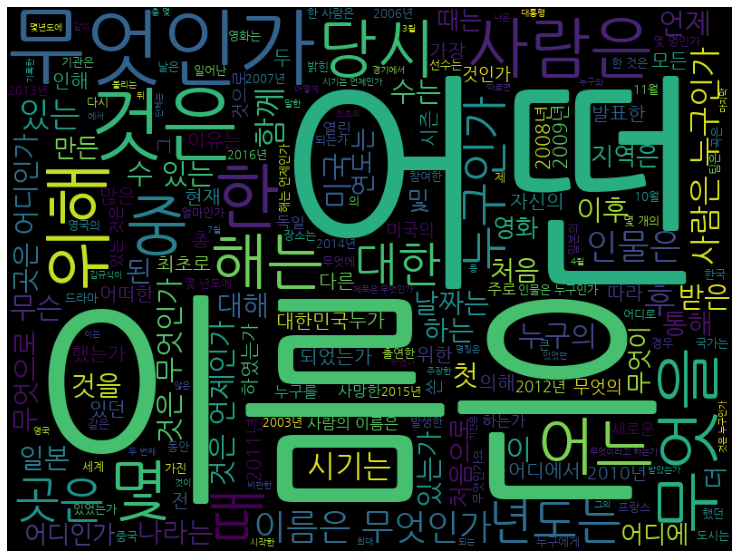

In [42]:
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_questions))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

### 명사 토큰 기준

(-0.5, 799.5, 599.5, -0.5)

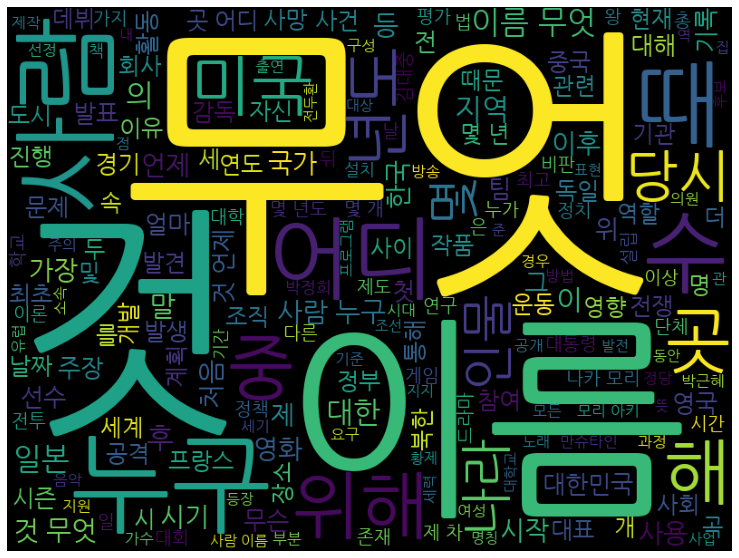

In [43]:
noun_extracted_qs = []
for q in sampled_questions:
    noun_extracted_qs += phoneme_tokenizer.nouns(q)

cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(noun_extracted_qs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')